In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df_train = pd.read_parquet('data/input_dataset-2.parquet')
df_test = pd.read_parquet('data/prediction_input.parquet')

## Remove irrellevant columns

Text(0, 0.5, 'Percentage [%]')

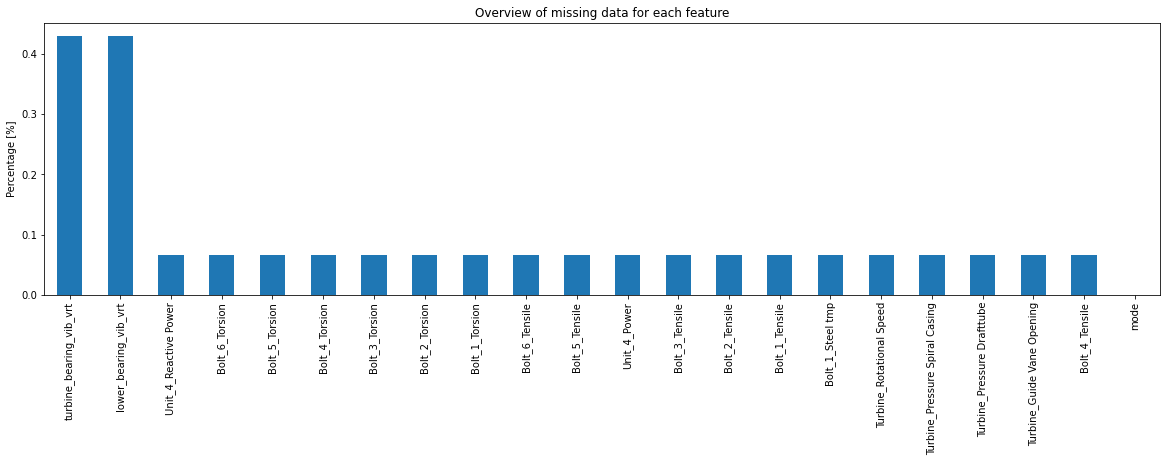

In [3]:
(df_train.isna().sum()/len(df_train)).sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title("Overview of missing data for each feature")
plt.ylabel("Percentage [%]")

In [4]:
cols_keep = list(df_test.columns) + [f'Bolt_{i}_Tensile' for i in range(1,7)]
cols_num = list(df_test.drop(columns='mode').columns)
cols_cat = ['mode']

In [5]:
# Extract relevant features
df_train = df_train[cols_keep]
df_train.head(3).T

timepoints,1970-12-19 09:51:44,1970-12-19 09:51:45,1970-12-19 09:51:46
Unit_4_Power,262.204308,262.104319,262.00433
Unit_4_Reactive Power,2.899036,3.34463,3.790223
Turbine_Guide Vane Opening,82.279976,82.277248,82.27452
Turbine_Pressure Drafttube,173.955216,173.989815,174.024413
Turbine_Pressure Spiral Casing,5310.799181,5311.219755,5311.640329
Turbine_Rotational Speed,107.964278,107.964273,107.964269
mode,operation,operation,operation
Bolt_1_Tensile,1598.48139,1598.477449,1598.479316
Bolt_2_Tensile,1480.989917,1480.989528,1481.003188
Bolt_3_Tensile,1684.247079,1684.261611,1684.270504


## Remove all rows with missing values

In [6]:
print('TRAINING SET')
print(f"Length of full dataset: {len(df_train):,}")
print(f"Remaining rows after dropping all NaNs: {len(df_train[~df_train.isna().any(axis=1)]):,}")
print(f"Loss: {100*(df_train.isna().any(axis=1).sum() / len(df_train)):.2f} %")
print()

print('TEST SET')
print(f"Length of full dataset: {len(df_test):,}")
print(f"Remaining rows after dropping all NaNs: {len(df_test[~df_test.isna().any(axis=1)]):,}")
print(f"Loss: {100*(df_test.isna().any(axis=1).sum() / len(df_test)):.2f} %")

TRAINING SET
Length of full dataset: 1,874,087
Remaining rows after dropping all NaNs: 1,750,000
Loss: 6.62 %

TEST SET
Length of full dataset: 226,364
Remaining rows after dropping all NaNs: 226,364
Loss: 0.00 %


In [7]:
# Remove rows that contain any missing values
df_train = df_train.dropna()
assert df_train.isna().any().sum() == 0

## Create sliding window

In [8]:
# Create timeslots that contain "safe" data without jumps

time_jumps_sec = (df_train.index[1:] - df_train.index[:-1]).seconds

timeslots_start = [df_train.index[0]] + list(df_train.index[1:][time_jumps_sec>1])
timeslots_end = list(df_train.index[:-1][time_jumps_sec>1]) + [df_train.index[-1]]

timeslots = [(ts_start, ts_end) for ts_start, ts_end in zip(timeslots_start, timeslots_end)]
timeslots

[(Timestamp('1970-12-19 09:51:44'), Timestamp('1970-12-24 00:01:29')),
 (Timestamp('1970-12-24 03:55:18'), Timestamp('1970-12-24 03:58:53')),
 (Timestamp('1970-12-24 04:00:46'), Timestamp('1970-12-27 22:00:52')),
 (Timestamp('1970-12-28 06:25:21'), Timestamp('1970-12-28 06:28:33')),
 (Timestamp('1970-12-28 06:30:49'), Timestamp('1970-12-28 08:00:50')),
 (Timestamp('1970-12-28 08:16:23'), Timestamp('1970-12-28 08:19:31')),
 (Timestamp('1970-12-28 08:20:27'), Timestamp('1970-12-29 00:01:08')),
 (Timestamp('1970-12-29 04:41:21'), Timestamp('1970-12-29 04:44:38')),
 (Timestamp('1970-12-29 04:46:47'), Timestamp('1970-12-29 18:49:21')),
 (Timestamp('1970-12-29 18:50:26'), Timestamp('1970-12-29 19:01:28')),
 (Timestamp('1970-12-29 19:55:16'), Timestamp('1970-12-29 19:58:50')),
 (Timestamp('1970-12-29 20:00:47'), Timestamp('1970-12-29 20:26:25')),
 (Timestamp('1970-12-31 11:58:50'), Timestamp('1970-12-31 12:02:32')),
 (Timestamp('1970-12-31 12:04:56'), Timestamp('1970-12-31 17:46:11')),
 (Time

In [9]:
# Example: Notice the jump in time
# This timeslot contains the timeslot end + the next two
# timesteps (which belongs would belong to the next timeslot)
df_train.loc[timeslots[0][1]:].head(3)

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,,,,,,,,
1970-12-24 00:01:29,101.249005,-18.795975,40.571212,223.112684,5497.962538,105.981726,operation,1598.500102,1478.786592,1683.053715,1596.922610,1633.424227,1670.371219
1970-12-24 03:55:18,0.000000,0.000000,1.235328,230.235378,4635.442549,0.955234,start,1523.662082,1425.632422,1665.702272,1556.012626,1596.237456,1610.361362
1970-12-24 03:55:19,0.000000,0.000000,1.237633,230.158516,4671.412655,0.957016,start,1524.566894,1426.169392,1665.869544,1556.394219,1596.612592,1610.871875


In [21]:
WINDOWS_SIZE = 3 # dt.timedelta(seconds=30)
TIMESHIFT_COLS = df_test.columns

df_timeslots = [df_train[ts_start:ts_end].copy() for ts_start, ts_end in timeslots]
new_df = []

for df_timeslot in df_timeslots:
    # TODO: Create look-back features with WINDOWS_SIZE seconds look-back
    for col in TIMESHIFT_COLS:
        for i in range(1, WINDOWS_SIZE):
            df_timeslot.loc[:,f"{col}_t-{i}"] = df_timeslot.loc[:,col].shift(i)

    df_timeslot = df_timeslot.dropna()
    df_timeslot = df_timeslot.reindex(sorted(df_timeslot.columns), axis=1)
    new_df.append(df_timeslot)

In [22]:
df_with_lookback = pd.concat(new_df, axis=0)
df_with_lookback.head().T

timepoints,1970-12-19 09:51:46,1970-12-19 09:51:47,1970-12-19 09:51:48,1970-12-19 09:51:49,1970-12-19 09:51:50
Bolt_1_Tensile,1598.479316,1598.490184,1598.494073,1598.498916,1598.494084
Bolt_2_Tensile,1481.003188,1481.028827,1481.059017,1481.075521,1481.092801
Bolt_3_Tensile,1684.270504,1684.270683,1684.271062,1684.276622,1684.291053
Bolt_4_Tensile,1601.374254,1601.383179,1601.378391,1601.380601,1601.386081
Bolt_5_Tensile,1635.583464,1635.581384,1635.591746,1635.607884,1635.615492
Bolt_6_Tensile,1674.841318,1674.843245,1674.8723,1674.924469,1674.965513
Turbine_Guide Vane Opening,82.27452,82.271792,82.269064,82.266336,82.263608
Turbine_Guide Vane Opening_t-1,82.277248,82.27452,82.271792,82.269064,82.266336
Turbine_Guide Vane Opening_t-2,82.279976,82.277248,82.27452,82.271792,82.269064
Turbine_Pressure Drafttube,174.024413,174.059012,174.153819,174.422046,174.701145
